In [1727]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import math

In [1728]:
image_path = "images/hack2.png"

In [1729]:
def display_image(title, image):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.axis('off')
    if len(image.shape) == 2 or image.shape[2] == 1:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [1730]:
# ## Basic reading image and display

original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
if original_image is None:
    raise ValueError(f"Could not read image from {image_path}")


In [1731]:
# ## Grayscale conversion

gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
# display_image("Grayscale Image", gray_image)

In [1732]:
# print("Threshold to separate pieces from background")
_, binary_image = cv2.threshold(gray_image, 30, 255, cv2.THRESH_BINARY)
# display_image("Binary Image", binary_image)

In [1733]:
kernel = np.ones((12, 12), np.uint8)

# Close = filling the holes
morph_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
# Open = removing the noise
morph_image = cv2.morphologyEx(morph_image, cv2.MORPH_OPEN, kernel)
# display_image("Morph Operations", morph_image)

In [1734]:
# print("Filling holes in puzzle pieces")
contours_fill, _ = cv2.findContours(morph_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours_fill:
    cv2.drawContours(morph_image, [cnt], 0, 255, -1)
# display_image("Filled Holes", morph_image)

In [1735]:
# ## Contours finding
contours, _ = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# print(f"Found {len(contours)} potential puzzle pieces")

In [1736]:
# print("Filtering contours by size")
contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
if len(contours) > 1:
    reference_area = cv2.contourArea(contours[1])
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > reference_area / 3]
# print(f"After filtering: {len(contours)} puzzle pieces")

In [1737]:
# print("Drawing contours of the original image")
contour_image = original_image.copy()
# cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

In [1738]:
output_folder_pieces = "images/extracted_pieces"
os.makedirs(output_folder_pieces, exist_ok=True)

output_folder_contours = "images/extracted_contours"
os.makedirs(output_folder_contours, exist_ok=True)

output_corner_folder = "images/extracted_corners"
os.makedirs(output_corner_folder, exist_ok=True)

output_transparent_folder = "images/transparent_pieces"
os.makedirs(output_transparent_folder, exist_ok=True)

output_plots_folder = "images/corner_plots"
os.makedirs(output_plots_folder, exist_ok=True)

output_canvas = "images/canvas"
os.makedirs(output_canvas, exist_ok=True)

output_oriented_folder = "images/oriented_pieces"
os.makedirs(output_oriented_folder, exist_ok=True)

output_edges_and_corner_folder = "images/edges_and_corners"
os.makedirs(output_edges_and_corner_folder, exist_ok=True)


output_matching = "images/matching"
os.makedirs(output_matching, exist_ok=True)

output_tests = "images/tests"
os.makedirs(output_tests, exist_ok=True)

In [1739]:
class Edge:
    def __init__(self, edge_id, edge_type, left_corner, right_corner):
        self.edge_type = edge_type
        self.edge_id = edge_id
        self.left_corner = left_corner
        self.right_corner = right_corner
        self.contour_indices = []
        self.length = None
        self.orientation = None
        self.color_edge_line = None

In [1740]:
class puzzlePiece:
    def __init__(self, piece_id):
        self.piece_id = piece_id
        self.absolute_contour = None
        self.relative_contour = None
        self.corners = None
        self.absolute_center = None
        self.relative_center = None
        self.contour_polar = None
        self.rotation_matrix = None
        self.edges = None
        self.edges_cat = None
        self.edges_ord = None
        self.piece_type = None
        self.mask = None
        self.bounding_rect = None
        self.absolute_coords = None
        self.relative_coords = None
        self.color_stats = None
        self.cropped_image = None
        self.relative_mask = None
        self.transparent_image = None

        self.rotation_angle = None
        self.rotation_matrix = None
        self.expanded_image = None
        self.expansion_offset = None  # (x_offset, y_offset)
        self.expansion_ratio = None
        self.rotated_image = None
        self.rotated_center = None
        self.rotated_corners = []  # List of rotated corner coordinates
        self.rotated_edges = []  # List of rotated edge data
        self.rotated_contour = None  # Full rotated contour
        self.flat_edge_id = None  # Which edge ID is the flat one being rotated


    def __repr__(self):
        ret = ""
        ret += f"{self.piece_id}\n"
        ret += f"Contour: {len(self.contour)}\n"
        ret += f"Corners: {self.corners}\n"

        return ret

In [1741]:
class Puzzle:
    _counter = 0
    def __init__(self):
        self.puzzle_id = Puzzle._counter
        Puzzle._counter += 1
        self.all_pieces = {}
        self.corners_pieces = []
        self.borders_pieces = []
        self.middle_pieces = []

In [1742]:
my_puzzle = Puzzle()

In [1743]:
for contours_indices in range(len(contours)):
    # In[108]:
    selected_image_index = contours_indices


    this_piece = puzzlePiece(selected_image_index)
    this_piece.contour = contours[contours_indices]

    # In[109]:
    piece_images = []

    i = selected_image_index
    contour = contours[i]

    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [contour], 0, 255, -1)

    this_piece.mask = mask

    piece = np.zeros_like(original_image)
    piece[mask == 255] = original_image[mask == 255]
    x, y, w, h = cv2.boundingRect(contour)
    cropped_piece = piece[y:y + h, x:x + w]
    piece_images.append(cropped_piece)

    this_piece.bounding_rect = (x, y, w, h)
    this_piece.absolute_contour = contour
    this_piece.relative_contour = contour - np.array([[x, y]])
    this_piece.cropped_image = cropped_piece

    relative_mask = mask[y:y+h, x:x+w]
    this_piece.relative_mask = relative_mask

    transparent_piece = np.zeros((h, w, 4), dtype=np.uint8)
    transparent_piece[:, :, 0:3] = cropped_piece

    transparent_piece[:, :, 3] = relative_mask
    this_piece.transparent_image = transparent_piece

    # transparent_path = os.path.join(output_transparent_folder, f"piece_{selected_image_index}_transparent.png")
    # cv2.imwrite(transparent_path, transparent_piece)


    # piece_path = os.path.join(output_folder_pieces, f"piece_{selected_image_index + 1}.png")
    # cv2.imwrite(piece_path, cropped_piece)
    contour_piece = cropped_piece.copy()

    # display_image(f"Cropped piece {selected_image_index+1}", contour_piece)


    # In[110]:
    M = cv2.moments(contour)

    if M["m00"] == 0:
        print("ERROR")
    centroid_x = int(M["m10"] / M["m00"])
    centroid_y = int(M["m01"] / M["m00"])
    cv2.circle(contour_piece, (centroid_x - x, centroid_y - y), 2, (0, 0, 255), -1)
    # display_image(f"Centroid {i+1}", contour_piece)

    this_piece.relative_center = (centroid_x - x, centroid_y - y)
    this_piece.absolute_center = (centroid_x, centroid_y)

    # In[113]:
    contour_points = contour - np.array([x, y])
    distances = []
    angles = []
    for point in contour:
        px, py = point[0]
        dx = px - centroid_x
        dy = py - centroid_y
        distance = np.sqrt(dx ** 2 + dy ** 2)
        angle = np.arctan2(dy, dx)
        distances.append(distance)
        angles.append(angle)

    angles_deg = np.array([(a * 180 / np.pi) % 360 for a in angles])
    distances = gaussian_filter1d(distances, sigma=2)

    this_piece.contour_polar = (angles_deg, distances)

    delta_s = len(angles_deg) // 4

    angles_deg_s = np.roll(angles_deg, -delta_s)
    distances_s = np.roll(distances, -delta_s)

    # find the maxima
    min_distance_between_peaks = len(distances) // 20
    all_peak_indices, all_peak_properties = find_peaks(distances,                                 distance=min_distance_between_peaks,prominence=2)

    all_peak_indices_s, all_peak_properties_s = find_peaks(distances_s,                                 distance=min_distance_between_peaks,prominence=2)
    all_peak_indices_u = [(x+delta_s)%len(angles_deg) for x in all_peak_indices_s]
    all_peak_indices_f = [y for y in all_peak_indices_u if y not in all_peak_indices]

    for val in all_peak_indices_f:
        pos = np.searchsorted(all_peak_indices, val)
        all_peak_indices = np.insert(all_peak_indices, pos, val)

    inverted_distances = [-d for d in distances]
    all_min_indices, all_min_properties = find_peaks(inverted_distances,
                                                     distance=min_distance_between_peaks, prominence=0.1)

    # Calculate min_distances_avg
    min_distances = [distances[min_idx] for min_idx in all_min_indices]
    min_distances_avg = np.mean(min_distances)

    # Filtering the peaks - following EXACT same logic as original
    max_angle_diff = 25
    delCounter = 0

    # Convert to list for easier manipulation if needed
    remaining_peak_indices = all_peak_indices.tolist() if isinstance(all_peak_indices,
                                                                     np.ndarray) else all_peak_indices.copy()

    while True:
        removals_made = False

        for k in range(len(remaining_peak_indices)):
            if len(remaining_peak_indices) <= 1:
                break

            if distances[remaining_peak_indices[k]] <= min_distances_avg:
                remaining_peak_indices.pop(k)
                break

            next_k = (k + 1) % len(remaining_peak_indices)  # Wrap-around logic
            angle_k = angles_deg[remaining_peak_indices[k]]
            angle_next_k = angles_deg[remaining_peak_indices[next_k]]

            if abs(angle_next_k - angle_k) < max_angle_diff:
                delCounter += 1
                removals_made = True

                dist_k = distances[remaining_peak_indices[k]]
                dist_next_k = distances[remaining_peak_indices[next_k]]

                if dist_k < dist_next_k:
                    remaining_peak_indices.pop(k)
                else:
                    remaining_peak_indices.pop(next_k)

                break

        if not removals_made or len(remaining_peak_indices) <= 1:
            break

    all_peak_indices = np.array(remaining_peak_indices) if isinstance(all_peak_indices,
                                                                      np.ndarray) else remaining_peak_indices

    new_min_indice = all_min_indices.copy()

    min_angles = [angles_deg[min_idx] for min_idx in new_min_indice]
    min_distances = [distances[min_idx] for min_idx in new_min_indice]

    def robust_pointiness(angles_deg, distances, peak_indices, window_small=5, window_large=15):
        pointiness_scores = []

        for peak_idx in peak_indices:
            small_left = max(0, peak_idx - window_small)
            small_right = min(len(distances) - 1, peak_idx + window_small)
            small_window = distances[small_left:small_right+1]

            large_left = max(0, peak_idx - window_large)
            large_right = min(len(distances) - 1, peak_idx + window_large)
            large_window = distances[large_left:large_right+1]

            peak_height = distances[peak_idx]
            small_avg = np.mean(small_window)
            large_avg = np.mean(large_window)

            pointiness = (peak_height - large_avg) * (small_avg - large_avg)
            pointiness_scores.append(pointiness)

        return pointiness_scores

    pointiness_scores = robust_pointiness(angles_deg, distances, all_peak_indices)

    top_4_indices = sorted(range(len(pointiness_scores)),
                          key=lambda i: pointiness_scores[i],
                          reverse=True)[:4]

    top_4_indices = sorted(top_4_indices)
    top_4_peak_indices = [all_peak_indices[i] for i in top_4_indices]

    temp = [int(w) for w in top_4_peak_indices]
    remaining_indices = [z for z in all_peak_indices if z not in temp]

    top_4_angles = [angles_deg[i] for i in top_4_peak_indices]
    top_4_distances = [distances[i] for i in top_4_peak_indices]

    peak_angles = angles_deg[all_peak_indices]
    peak_distances = distances[all_peak_indices]

    this_piece.corners_idx = top_4_peak_indices

    # ## Edge type detection

    def exists_peak_between(a,b,peak_indices):
        if b < a:
            for p in peak_indices:
                if p > a or p < b:
                    # print(f"Found maxima {p}")
                    return True

        else:
            for p in peak_indices:
                if p > a and p < b:
                    # print(f"Found maxima {p}")
                    return True

            # print("no peak between")
            return False

    resize_factor = 0.8

    def exists_minima_between(a,b,min_indices):
        if b < a:
            for p in min_indices:
                if p > a or p < b:
                    # hack to set distance smaller than custom threshold
                    if distances[p] < ((max(distances[a], distances[b])*resize_factor ) /1.41):
                        # print(f"Found minima {p}")
                        return True
                    else:
                        return False

        else:
            for p in min_indices:
                if p > a and p < b:
                    if distances[p] < ((max(distances[a], distances[b])*resize_factor ) /1.41):
                        # print(f"Found minima {p}")
                        return True
                    else:
                        return False

            # print("no min between")
            return False

    edge_types = {0: "FLAT", 1: "IN", 2: "OUT"}
    # print(all_min_indices)

    def get_edge_type(a, b):
        # print("-----")
        # print(a, b)
        # print(angles_deg[a], angles_deg[b])
        #
        # print(remaining_indices)
        # print([angles_deg[r] for r in remaining_indices])
        if exists_peak_between(a, b, remaining_indices):
            return 2
        else:
            if exists_minima_between(a, b, all_min_indices):
                return 1
            else:
                return 0


    edges = []

    edges_cat = {0: 0, 1: 0, 2: 0}
    edges_ord = []

    for c, corner in enumerate(top_4_peak_indices):
        corner1 = top_4_peak_indices[c]
        corner2 = top_4_peak_indices[(c+1) % len(top_4_peak_indices)]

        type = get_edge_type(corner1, corner2)
        edges_cat[type] += 1
        edges_ord.append(type)

        edges.append((chr(97 + c), corner1, corner2, get_edge_type(corner1, corner2)))

    this_piece.edges_desc = ("EDGE_ID", "CORNER1", "CORNER2", "EDGE_TYPE")

    # edge_types = {0: "FLAT", 1: "IN", 2: "OUT"}
    # piece_types = {0 : "CORNER", 1 : "BORDER", 2 : "MIDDLE"}

    # print("----edges cat---")
    # print(edges_cat)

    if edges_cat[0] == 2:
        piece_type = 0
        my_puzzle.corners_pieces.append(selected_image_index)
    elif edges_cat[0] == 1:
        piece_type = 1
        my_puzzle.borders_pieces.append(selected_image_index)
    else:
        piece_type = 2
        my_puzzle.middle_pieces.append(selected_image_index)

    this_piece.edges = edges
    this_piece.edges_cat = edges_cat
    this_piece.edges_ord = edges_ord
    this_piece.piece_type = piece_type

    ## Draw edges types with Corners
    color_edge_corner_piece = contour_piece.copy()

    contour_points = contour.reshape(-1, 2)
    contour_points_shifted = contour_points - np.array([x, y])  # apply shift

    edge_colors = {
        0: (0, 0, 255),   # Blue for edge_type 0
        1: (255, 255, 0), # Yellow for edge_type 1
        2: (0, 255, 0)    # Green for edge_type 2
    }

    corner_color = (255, 0, 255)  # Purple color for corners
    for edge_id, start_idx, end_idx, edge_type in edges:
        start_px, start_py = contour_points[start_idx] - np.array([x, y])
        end_px, end_py = contour_points[end_idx] - np.array([x, y])

        color = edge_colors[edge_type]
        if start_idx < end_idx:
            indices = range(start_idx, end_idx)
        else:
            indices = list(range(start_idx, len(contour_points))) + list(range(0, end_idx))

        for idx in indices:
            px, py = contour_points_shifted[idx]
            color_edge_corner_piece[py, px] = color

        cv2.circle(color_edge_corner_piece, (start_px, start_py), 3, corner_color, -1)  # Start corner
        cv2.circle(color_edge_corner_piece, (end_px, end_py), 3, corner_color, -1)    # End corner

    edges_corners_path = os.path.join(output_tests, f"edges_corners_x_{selected_image_index}.png")
    cv2.imwrite(edges_corners_path, color_edge_corner_piece)

    my_puzzle.all_pieces[selected_image_index] = this_piece


In [1744]:
print("----------- STATS ---------- ")

print(f"Number of pieces: {len(my_puzzle.all_pieces)}")

print("Corners: ", my_puzzle.corners_pieces)
print("Borders: ", my_puzzle.borders_pieces)
print("Middles: ", my_puzzle.middle_pieces)

----------- STATS ---------- 
Number of pieces: 24
Corners:  [2, 6, 17, 19]
Borders:  [1, 4, 5, 7, 9, 12, 13, 14, 16, 18, 21, 22]
Middles:  [0, 3, 8, 10, 11, 15, 20, 23]


## Algorithm to find the puzzle size

In [1745]:
def find_puzzle_size(total, corners, borders, middles):
    for h in range(1, total + 1):
        if total % h != 0:
            continue
        w = total // h
        if corners == 4 and \
           borders == 2 * (w + h - 4) and \
           middles == (w - 2) * (h - 2):
            return (w, h)
    return None

In [1746]:
puzzle_r, puzzle_c = find_puzzle_size(len(my_puzzle.all_pieces), len(my_puzzle.corners_pieces), len(my_puzzle.borders_pieces), len(my_puzzle.middle_pieces))
print(puzzle_r)
print(puzzle_c)

6
4


In [1747]:
def display_image_cv2(title, image):
    if len(image.shape) == 3 and image.shape[2] == 4:
        white_background = np.ones((image.shape[0], image.shape[1], 3), dtype=np.uint8) * 255

        alpha = image[:, :, 3] / 255.0

        alpha_3channel = np.stack([alpha, alpha, alpha], axis=2)
        bgr = image[:, :, 0:3]

        result = (alpha_3channel * bgr + (1 - alpha_3channel) * white_background).astype(np.uint8)

        cv2.imshow(title, result)
    else:
        cv2.imshow(title, image)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [1748]:
# target_index = 5
# test_piece = my_puzzle.all_pieces[target_index]

## Piece reorientation

pieces with a straight edge -> y axis orientation

In [1749]:
# Create a new white canvas to place all oriented pieces
# Define this before the loop
canvas_width = 1500
canvas_height = 1200
piece_spacing = 50
margin = 100

max_pieces_per_row = puzzle_r
canvas = np.ones((canvas_height, canvas_width, puzzle_c), dtype=np.uint8) * 255  # White background with alpha

# Keep track of the maximum piece height in each row
row_heights = [0] * (len(my_puzzle.borders_pieces + my_puzzle.corners_pieces) // max_pieces_per_row + 1)
piece_positions = []

current_x = margin
current_y = margin
max_height_in_row = 0
piece_count = 0

In [1750]:

class Canvas:
    def __init__(self, width, height, max_pieces_per_row=6,
                 column_spacing=100, row_spacing=50, margin=100):
        self.width = width
        self.height = height
        self.max_pieces_per_row = max_pieces_per_row
        self.column_spacing = column_spacing  # Horizontal spacing between pieces
        self.row_spacing = row_spacing  # Vertical spacing between rows
        self.margin = margin

        # Initialize canvas with transparent white background
        self.canvas = np.ones((height, width, 4), dtype=np.uint8) * 255
        self.canvas[:,:,3] = 255  # Full alpha

        # Placement tracking
        self.current_x = margin
        self.current_y = margin
        self.max_height_in_row = 0
        self.piece_count = 0
        # Avoid division by zero when column_spacing is 0
        row_heights_size = max_pieces_per_row * 2 if column_spacing == 0 else ((width // (column_spacing + 1)) + 1)
        self.row_heights = [0] * row_heights_size
        self.piece_positions = []  # Store (piece_id, x, y) tuples

        # For puzzle reconstruction
        self.grid = {}  # Dictionary mapping (x,y) grid positions to piece IDs

    def rotate_piece(self, piece, rotations=1):
        # Make sure rotations is between 0 and 3
        rotations = rotations % 4
        if rotations == 0:
            return piece  # No rotation needed

        print(f"Rotating piece {piece.piece_id} by {rotations * 90} degrees")

        # Step 1: Rotate the image
        h, w = piece.rotated_image.shape[:2]
        rotated_image = piece.rotated_image.copy()

        for _ in range(rotations):
            rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_CLOCKWISE)

        # Step 2: Rotate the corners
        rotated_corners = piece.rotated_corners.copy()
        center = (w/2, h/2)

        for _ in range(rotations):
            # For each 90-degree rotation, (x,y) -> (y, w-x)
            new_corners = []
            for x, y in rotated_corners:
                # Rotate around center
                new_x = center[0] + (y - center[1])
                new_y = center[1] - (x - center[0])
                new_corners.append((int(new_x), int(new_y)))
            rotated_corners = new_corners

        # Step 3: Update the piece's properties
        piece.rotated_image = rotated_image
        piece.rotated_corners = rotated_corners

        # Step 4: Rotate the rotated center
        if piece.rotated_center:
            cx, cy = piece.rotated_center
            rotated_center = (cx, cy)
            for _ in range(rotations):
                rx = center[0] + (rotated_center[1] - center[1])
                ry = center[1] - (rotated_center[0] - center[0])
                rotated_center = (int(rx), int(ry))
            piece.rotated_center = rotated_center

        # Step 5: Update the edges to reflect the rotation
        # Rotate the edges_ord list
        if piece.edges_ord:
            piece.edges_ord = piece.edges_ord[-rotations:] + piece.edges_ord[:-rotations]

        # For edge connections, we need to also rotate the edge indices for proper matching
        if hasattr(piece, 'edges') and piece.edges:
            # We need to create a new list with updated edge indices
            rotated_edges = []
            for i in range(len(piece.edges)):
                # Calculate the new edge index after rotation
                new_idx = (i + rotations) % len(piece.edges)
                edge_data = list(piece.edges[i])  # Convert tuple to list for modification

                # Update the edge ID (first element is typically an ID)
                edge_data[0] = chr(ord('a') + new_idx)

                # The corner indices need to be remapped too, but this requires the full contour
                # For now, we'll just update the other elements
                rotated_edges.append(tuple(edge_data))

            # Sort by the new edge IDs if needed
            # piece.edges = sorted(rotated_edges, key=lambda x: x[0])

        return piece

    def display(self):
        # Create a figure with appropriate size
        fig_width = min(12, self.width / 100)
        fig_height = min(10, self.height / 100)
        plt.figure(figsize=(fig_width, fig_height))

        # Handle image with alpha channel (transparency)
        if self.canvas.shape[2] == 4:
            # Create RGB image with white background
            rgb_image = np.ones((self.canvas.shape[0], self.canvas.shape[1], 3), dtype=np.uint8) * 255

            # Extract alpha channel
            alpha = self.canvas[:, :, 3] / 255.0

            # Create 3-channel alpha
            alpha_3channel = np.stack([alpha, alpha, alpha], axis=2)

            # Extract BGR channels and convert to RGB
            bgr = self.canvas[:, :, :3]
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

            # Blend using alpha
            result = (alpha_3channel * rgb + (1 - alpha_3channel) * rgb_image).astype(np.uint8)

            plt.imshow(result)
        else:
            # Regular RGB image
            plt.imshow(cv2.cvtColor(self.canvas, cv2.COLOR_BGR2RGB))

        plt.axis('off')
        plt.title("Puzzle Reconstruction")
        plt.tight_layout()
        plt.show()

    def place_piece(self, piece, grid_x=None, grid_y=None, rotations=0):
        # Apply any requested rotation
        if rotations > 0:
            self.rotate_piece(piece, rotations)

        # If grid positions are specified, use them for placement
        if grid_x is not None and grid_y is not None:
            # Calculate position based on grid coordinates
            x = self.margin + grid_x * self.column_spacing
            y = self.margin + grid_y * self.row_spacing
            self.grid[(grid_x, grid_y)] = piece.piece_id

            # For reconstruction, we need to adjust according to piece features
            # This depends on your specific needs for how pieces should align

            # Store placement info
            self.piece_positions.append((piece.piece_id, x, y))

            # Set current position for drawing
            self.current_x = x
            self.current_y = y
        else:
            # Calculate position on the grid (for regular display)
            row = self.piece_count // self.max_pieces_per_row
            col = self.piece_count % self.max_pieces_per_row

            # Start a new row if needed
            if col == 0 and self.piece_count > 0:
                self.current_y += self.max_height_in_row + self.row_spacing
                self.current_x = self.margin
                self.max_height_in_row = 0

        # Get piece dimensions
        piece_height, piece_width = piece.rotated_image.shape[:2]
        self.max_height_in_row = max(self.max_height_in_row, piece_height)

        # Get reference corner (first rotated corner), if available
        ref_corner = (0, 0)
        if hasattr(piece, 'rotated_corners') and piece.rotated_corners and hasattr(piece, 'flat_edge_id'):
            ref_corner = piece.rotated_corners[piece.flat_edge_id]

        # Calculate adjusted placement coordinates
        adjusted_x = self.current_x - ref_corner[0]
        adjusted_y = self.current_y - ref_corner[1]

        # Make sure we don't exceed canvas dimensions
        y_start = max(0, adjusted_y)
        x_start = max(0, adjusted_x)
        canvas_y_end = min(self.height, adjusted_y + piece_height)
        canvas_x_end = min(self.width, adjusted_x + piece_width)

        # Calculate corresponding regions in rotated image
        img_y_start = max(0, -adjusted_y)
        img_x_start = max(0, -adjusted_x)
        img_y_end = img_y_start + (canvas_y_end - y_start)
        img_x_end = img_x_start + (canvas_x_end - x_start)

        if (canvas_y_end > y_start) and (canvas_x_end > x_start):
            # Alpha blending
            for c in range(4):
                mask = piece.rotated_image[img_y_start:img_y_end, img_x_start:img_x_end, 3:4] / 255.0
                if c < 3:  # RGB channels
                    self.canvas[y_start:canvas_y_end, x_start:canvas_x_end, c] = (
                        self.canvas[y_start:canvas_y_end, x_start:canvas_x_end, c] * (1 - mask[:,:,0]) +
                        piece.rotated_image[img_y_start:img_y_end, img_x_start:img_x_end, c] * mask[:,:,0]
                    )
                else:  # Alpha channel
                    self.canvas[y_start:canvas_y_end, x_start:canvas_x_end, 3] = np.maximum(
                        self.canvas[y_start:canvas_y_end, x_start:canvas_x_end, 3],
                        piece.rotated_image[img_y_start:img_y_end, img_x_start:img_x_end, 3]
                    )

        # Add piece ID text - only if requested
        if piece.rotated_center and not hasattr(piece, 'skip_id_label'):
            center_x = x_start + (piece.rotated_center[0] - img_x_start)
            center_y = y_start + (piece.rotated_center[1] - img_y_start)
            # cv2.putText(self.canvas, str(piece.piece_id), (center_x, center_y),
            #     cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255, 255), 2)

        # Debug marker
        cv2.circle(self.canvas, (self.current_x, self.current_y), 3, (0, 0, 255, 255), -1)

        # Move to next position for regular placement
        if grid_x is None or grid_y is None:
            self.current_x += self.column_spacing + 100
            self.piece_count += 1

        return self.piece_count - 1  # Return the position index

    def place_corner(self, piece, corner_position="top-left"):
        # Determine grid position based on requested corner
        if corner_position == "top-left":
            grid_x, grid_y = 0, 0
            target_flat_edges = [0, 3]  # North and West
        elif corner_position == "top-right":
            grid_x, grid_y = self.max_pieces_per_row - 1, 0
            target_flat_edges = [0, 1]  # North and East
        elif corner_position == "bottom-left":
            grid_x, grid_y = 0, self.max_pieces_per_row - 1
            target_flat_edges = [2, 3]  # South and West
        elif corner_position == "bottom-right":
            grid_x, grid_y = self.max_pieces_per_row - 1, self.max_pieces_per_row - 1
            target_flat_edges = [1, 2]  # East and South
        else:
            raise ValueError(f"Invalid corner position: {corner_position}")

        # Find which edges of the piece are flat (type 0)
        flat_edge_indices = [i for i, edge_data in enumerate(piece.edges) if edge_data[3] == 0]
        print(f"Flat edges for piece {piece.piece_id}: {flat_edge_indices}")

        # Determine how many rotations are needed
        rotations_needed = None
        for r in range(4):
            # Calculate where the flat edges would be after r rotations
            rotated_flat_edges = [(idx + r) % 4 for idx in flat_edge_indices]
            rotated_flat_edges.sort()

            if rotated_flat_edges == sorted(target_flat_edges):
                rotations_needed = r
                break

        # If we couldn't find a valid rotation, try best approximation
        if rotations_needed is None:
            print("Warning: Couldn't find perfect corner orientation, using best approximation")
            # Try to match at least one flat edge
            for r in range(4):
                rotated_flat_edges = [(idx + r) % 4 for idx in flat_edge_indices]
                if any(edge in target_flat_edges for edge in rotated_flat_edges):
                    rotations_needed = r
                    break
            # If still none found, just use 0
            if rotations_needed is None:
                rotations_needed = 0

        print(f"Placing {corner_position} corner (piece {piece.piece_id}) with {rotations_needed * 90}° rotation")

        # Place the piece with the calculated rotation
        self.place_piece(piece, grid_x, grid_y, rotations=rotations_needed)

        # Add to the grid
        self.grid[(grid_x, grid_y)] = piece.piece_id

        # Print verification
        flat_edge_indices_after = [(i + rotations_needed) % 4 for i in flat_edge_indices]
        print(f"Flat edges after rotation: {flat_edge_indices_after}")

        return grid_x, grid_y

    def save(self, path):
        """Save the canvas to file"""
        cv2.imwrite(path, self.canvas)

    def get_piece_position(self, piece_id):
        """Get the position of a piece on the canvas"""
        for p_id, x, y in self.piece_positions:
            if p_id == piece_id:
                return (x, y)
        return None

In [1751]:
# First process and reorient all pieces
for index in (my_puzzle.borders_pieces + my_puzzle.corners_pieces):
    print("------- ROTATE TO ORTHOGONAL ORIENTATION ----------")
    print(f"Testing index: {index}")

    test_piece = my_puzzle.all_pieces[index]

    edge_id = 0

    print(test_piece.edges_ord)

    for k, id in enumerate(test_piece.edges_ord):
        print(f"Testing id: {id}")
        if id == 0:
            print(f"-> Found flat edge: {k}")
            edge_id = k
            break

    # Store the flat edge ID
    test_piece.flat_edge_id = edge_id

    corner1 = test_piece.edges[edge_id][1]
    corner2 = test_piece.edges[edge_id][2]

    point_1 = test_piece.relative_contour[corner1][0]
    point_2 = test_piece.relative_contour[corner2][0]

    vec = point_2 - point_1
    orth = np.array([0, 1])

    cos_theta = np.dot(vec, orth) / (np.linalg.norm(vec) * np.linalg.norm(orth))
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)

    det = vec[0] * orth[1] - vec[1] * orth[0]
    sign = -1 if det > 0 else 1

    # Apply the sign to the angle
    angle_deg = sign * angle_deg

    # Store rotation angle
    test_piece.rotation_angle = angle_deg

    image_with_center = test_piece.transparent_image.copy()
    cv2.circle(image_with_center, test_piece.relative_center, 2, (0, 0, 255, 255), -1)

    (h, w) = image_with_center.shape[:2]
    center = tuple(test_piece.relative_center)

    # Expand canvas
    old_h, old_w = image_with_center.shape[:2]
    expansion_ratio = 1.8
    new_w = int(old_w * expansion_ratio)
    new_h = int(old_h * expansion_ratio)

    # Calculate offsets to center the image in the expanded canvas
    x_offset = (new_w - old_w) // 2
    y_offset = (new_h - old_h) // 2

    # Store expansion data
    test_piece.expansion_ratio = expansion_ratio
    test_piece.expansion_offset = (x_offset, y_offset)

    # Create expanded canvas with transparent background
    expanded_image = np.zeros((new_h, new_w, 4), dtype=np.uint8)
    expanded_image[y_offset:y_offset+old_h, x_offset:x_offset+old_w] = image_with_center

    # Store expanded image
    test_piece.expanded_image = expanded_image

    # Update center for rotation
    new_center_x = test_piece.relative_center[0] + x_offset
    new_center_y = test_piece.relative_center[1] + y_offset
    new_center = (new_center_x, new_center_y)

    # Create rotation matrix for the expanded image
    M = cv2.getRotationMatrix2D(new_center, angle_deg, 1.0)

    # Store rotation matrix
    test_piece.rotation_matrix = M

    # Apply the rotation to the expanded image
    rotated_image = cv2.warpAffine(expanded_image, M, (new_w, new_h),
                                   flags=cv2.INTER_LINEAR,
                                   borderMode=cv2.BORDER_CONSTANT)

    # Store rotated image
    test_piece.rotated_image = rotated_image

    # Calculate the rotated points (need to adjust original points with offset)
    p1_offset = (point_1[0] + x_offset, point_1[1] + y_offset)
    p2_offset = (point_2[0] + x_offset, point_2[1] + y_offset)

    p1_rot = M @ np.array([p1_offset[0], p1_offset[1], 1])
    p2_rot = M @ np.array([p2_offset[0], p2_offset[1], 1])

    p1_rot = tuple(np.round(p1_rot).astype(int))
    p2_rot = tuple(np.round(p2_rot).astype(int))

    # Store rotated center
    rotated_center = M @ np.array([new_center[0], new_center[1], 1])
    test_piece.rotated_center = tuple(np.round(rotated_center[:2]).astype(int))

    # Initialize rotated corners list
    test_piece.rotated_corners = []
    test_piece.rotated_edges = []

    edge_colors = {
        0: (0, 0, 255, 255),   # Blue for edge_type 0 (flat edge)
        1: (255, 255, 0, 255), # Yellow for edge_type 1
        2: (0, 255, 0, 255),   # Green for edge_type 2
        3: (255, 0, 0, 255)    # Red for edge_type 3
    }

    corner_color = (255, 0, 255, 255)  # Purple color for corners

    colored_edges_image = rotated_image.copy()

    # Create a list to store the entire rotated contour
    rotated_contour = []

    # Rotate the entire contour
    for point in test_piece.relative_contour:
        pt = point[0]
        pt_offset = (pt[0] + x_offset, pt[1] + y_offset)
        pt_rot = M @ np.array([pt_offset[0], pt_offset[1], 1])
        pt_rot = tuple(np.round(pt_rot[:2]).astype(int))
        rotated_contour.append(pt_rot)

    # Store rotated contour
    test_piece.rotated_contour = np.array(rotated_contour)

    print("Edges structure:", test_piece.edges)

    for edge_idx, edge_data in enumerate(test_piece.edges):
        # [edge_type, corner1_idx, corner2_idx]
        edge_id = edge_data[0]
        corner1_idx = edge_data[1]
        corner2_idx = edge_data[2]
        edge_type = edge_data[3]

        # Get the corners in the original coordinate system
        c1 = test_piece.relative_contour[corner1_idx][0]
        c2 = test_piece.relative_contour[corner2_idx][0]

        # Apply the same offset as we did for the image expansion
        c1_offset = (c1[0] + x_offset, c1[1] + y_offset)
        c2_offset = (c2[0] + x_offset, c2[1] + y_offset)

        # Apply the rotation matrix to get the coordinates in the rotated image
        c1_rot = M @ np.array([c1_offset[0], c1_offset[1], 1])
        c2_rot = M @ np.array([c2_offset[0], c2_offset[1], 1])

        c1_rot = tuple(np.round(c1_rot[:2]).astype(int))
        c2_rot = tuple(np.round(c2_rot[:2]).astype(int))

        # Store rotated corners
        test_piece.rotated_corners.append(c1_rot)

        # Store rotated edge
        rotated_edge = {
            'edge_id': edge_id,
            'start_corner': c1_rot,
            'end_corner': c2_rot,
            'edge_type': edge_type
        }
        test_piece.rotated_edges.append(rotated_edge)

        # Draw a colored circle at each corner
        cv2.circle(colored_edges_image, c1_rot, 5, corner_color, -1)
        cv2.circle(colored_edges_image, c2_rot, 5, corner_color, -1)

        # Draw the edge with a colored line
        color = edge_colors.get(edge_type, (128, 128, 128, 255))  # Default gray if edge type not found
        cv2.line(colored_edges_image, c1_rot, c2_rot, color, 2)

        # Add edge number label
        mid_point = ((c1_rot[0] + c2_rot[0]) // 2, (c1_rot[1] + c2_rot[1]) // 2)
        cv2.putText(colored_edges_image, str(edge_idx), mid_point,
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0, 255), 2)

    # Use the colored edges image instead of rotated_image for placement
    test_piece.rotated_image = colored_edges_image

    # Draw circles on rotated points
    cv2.circle(test_piece.rotated_image, p1_rot, 4, (0, 255, 0, 255), -1)
    cv2.circle(test_piece.rotated_image, p2_rot, 4, (0, 255, 0, 255), -1)

    font_scale = max(0.8, test_piece.rotated_image.shape[0] / 500)
    cv2.putText(test_piece.rotated_image, str(test_piece.piece_id),
                test_piece.rotated_center, cv2.FONT_HERSHEY_SIMPLEX,
                font_scale, (0, 0, 255, 255), 2)



    # Save the individual piece for verification
    piece_path = os.path.join(output_oriented_folder, f"oriented_piece_{index}.png")
    cv2.imwrite(piece_path, test_piece.rotated_image)

print("All pieces oriented and processed!")

------- ROTATE TO ORTHOGONAL ORIENTATION ----------
Testing index: 1
[0, 2, 2, 2]
Testing id: 0
-> Found flat edge: 0
Edges structure: [('a', np.int64(99), np.int64(235), 0), ('b', np.int64(235), np.int64(427), 2), ('c', np.int64(427), np.int64(611), 2), ('d', np.int64(611), np.int64(99), 2)]
------- ROTATE TO ORTHOGONAL ORIENTATION ----------
Testing index: 4
[2, 1, 0, 2]
Testing id: 2
Testing id: 1
Testing id: 0
-> Found flat edge: 2
Edges structure: [('a', np.int64(111), np.int64(290), 2), ('b', np.int64(290), np.int64(495), 1), ('c', np.int64(495), np.int64(613), 0), ('d', np.int64(613), np.int64(111), 2)]
------- ROTATE TO ORTHOGONAL ORIENTATION ----------
Testing index: 5
[1, 2, 0, 2]
Testing id: 1
Testing id: 2
Testing id: 0
-> Found flat edge: 2
Edges structure: [('a', np.int64(87), np.int64(284), 1), ('b', np.int64(284), np.int64(489), 2), ('c', np.int64(489), np.int64(617), 0), ('d', np.int64(617), np.int64(87), 2)]
------- ROTATE TO ORTHOGONAL ORIENTATION ----------
Testing 

In [1752]:
# Create a canvas object with custom spacing
canvas_obj = Canvas(1500, 1200, column_spacing=100, row_spacing=-150, margin=100)

# Now place all the pieces on the canvas
piece_indices = my_puzzle.borders_pieces + my_puzzle.corners_pieces
print(f"Placing {len(piece_indices)} pieces on canvas...")

for index in piece_indices:
    piece = my_puzzle.all_pieces[index]
    print(f"Placing piece {index} on canvas (type: {piece.piece_type})")
    canvas_obj.place_piece(piece)

# Save the final canvas
canvas_path = os.path.join(output_canvas, "all_pieces_arranged.png")
canvas_obj.save(canvas_path)
print(f"Canvas saved to {canvas_path}")

Placing 16 pieces on canvas...
Placing piece 1 on canvas (type: 1)
Placing piece 4 on canvas (type: 1)
Placing piece 5 on canvas (type: 1)
Placing piece 7 on canvas (type: 1)
Placing piece 9 on canvas (type: 1)
Placing piece 12 on canvas (type: 1)
Placing piece 13 on canvas (type: 1)
Placing piece 14 on canvas (type: 1)
Placing piece 16 on canvas (type: 1)
Placing piece 18 on canvas (type: 1)
Placing piece 21 on canvas (type: 1)
Placing piece 22 on canvas (type: 1)
Placing piece 2 on canvas (type: 0)
Placing piece 6 on canvas (type: 0)
Placing piece 17 on canvas (type: 0)
Placing piece 19 on canvas (type: 0)
Canvas saved to images/canvas/all_pieces_arranged.png


In [1753]:
# Edge matching function to compute a matching score between two puzzle piece edges
def compute_edge_matching_score(piece1, edge1_idx, piece2, edge2_idx, debug=False):
    # Get edge types
    edge1_type = piece1.edges[edge1_idx][3]
    edge2_type = piece2.edges[edge2_idx][3]

    # Check if either edge is flat (type 0)
    if edge1_type == 0 or edge2_type == 0:
        if debug:
            print(f"Edge {edge1_idx} of piece {piece1.piece_id} or edge {edge2_idx} of piece {piece2.piece_id} is flat. Score = 0")


        return 0

    # Check if both edges are the same type (both IN or both OUT)
    if edge1_type == edge2_type:
        if debug:
            print(f"Both edges are type {edge1_type}. Score = 0")
        return 0


    # Check if pieces are border or corner pieces (have at least one flat edge)
    piece1_flat_edges = [i for i, edge in enumerate(piece1.edges) if edge[3] == 0]
    piece2_flat_edges = [i for i, edge in enumerate(piece2.edges) if edge[3] == 0]

    piece1_is_border = len(piece1_flat_edges) == 1
    piece1_is_corner = len(piece1_flat_edges) == 2
    piece2_is_border = len(piece2_flat_edges) == 1
    piece2_is_corner = len(piece2_flat_edges) == 2

    # Only apply the "opposite to flat edge" restriction for border pieces, not corners
    if (piece1_is_border and piece2_is_border):
        # For border pieces: check if current edge is opposite to the flat edge
        flat_edge1_idx = piece1_flat_edges[0] if piece1_flat_edges else None
        flat_edge2_idx = piece2_flat_edges[0] if piece2_flat_edges else None

        # Check if current edge is opposite to a flat edge (2 positions away in clockwise order)
        if (flat_edge1_idx is not None and (edge1_idx == (flat_edge1_idx + 2) % 4)) or \
           (flat_edge2_idx is not None and (edge2_idx == (flat_edge2_idx + 2) % 4)):
            if debug:
                print(f"Edge {edge1_idx} of piece {piece1.piece_id} or edge {edge2_idx} of piece {piece2.piece_id} is opposite to a flat edge on a border piece. Score = 0")
            return 0

    # For corner pieces, we need different rules
    if piece1_is_corner or piece2_is_corner:
        # If either piece is a corner, we need to make sure we're not trying to match
        # an edge that's adjacent to two flat edges with an edge that needs non-flat neighbors

        # For piece1, if it's a corner, check if the current edge is between two flat edges
        if piece1_is_corner:
            edge1_prev_idx = (edge1_idx - 1) % 4
            edge1_next_idx = (edge1_idx + 1) % 4

            # If both adjacent edges are flat, this edge can only match with specific edges
            if edge1_prev_idx in piece1_flat_edges and edge1_next_idx in piece1_flat_edges:
                # This edge is between two flat edges - it can only match with a similar edge
                # or an edge that doesn't require flat neighbors
                if piece2_is_corner:
                    edge2_prev_idx = (edge2_idx - 1) % 4
                    edge2_next_idx = (edge2_idx + 1) % 4

                    # If the other edge isn't between two flat edges, they can't match
                    if not (edge2_prev_idx in piece2_flat_edges and edge2_next_idx in piece2_flat_edges):
                        if debug:
                            print(f"Corner piece {piece1.piece_id} edge {edge1_idx} is between two flat edges, but corner piece {piece2.piece_id} edge {edge2_idx} is not. Score = 0")
                        return 0

        # Same check for piece2
        if piece2_is_corner:
            edge2_prev_idx = (edge2_idx - 1) % 4
            edge2_next_idx = (edge2_idx + 1) % 4

            if edge2_prev_idx in piece2_flat_edges and edge2_next_idx in piece2_flat_edges:
                if piece1_is_corner:
                    edge1_prev_idx = (edge1_idx - 1) % 4
                    edge1_next_idx = (edge1_idx + 1) % 4

                    if not (edge1_prev_idx in piece1_flat_edges and edge1_next_idx in piece1_flat_edges):
                        if debug:
                            print(f"Corner piece {piece2.piece_id} edge {edge2_idx} is between two flat edges, but corner piece {piece1.piece_id} edge {edge1_idx} is not. Score = 0")
                        return 0

    # Check if adjacent edges match for border pieces
    # For piece1: adjacent edges are (edge1_idx-1)%4 and (edge1_idx+1)%4
    # For piece2: adjacent edges are (edge2_idx-1)%4 and (edge2_idx+1)%4
    edge1_prev_idx = (edge1_idx - 1) % 4
    edge1_next_idx = (edge1_idx + 1) % 4
    edge2_prev_idx = (edge2_idx - 1) % 4
    edge2_next_idx = (edge2_idx + 1) % 4

    # Get the types of adjacent edges
    edge1_prev_type = piece1.edges[edge1_prev_idx][3]
    edge1_next_type = piece1.edges[edge1_next_idx][3]
    edge2_prev_type = piece2.edges[edge2_prev_idx][3]
    edge2_next_type = piece2.edges[edge2_next_idx][3]

    # Check if the adjacent edges match for border pieces
    # If edge1_prev is flat, then edge2_next should be flat
    # If edge1_next is flat, then edge2_prev should be flat
    if edge1_prev_type == 0 and edge2_next_type != 0:
        if debug:
            print(f"Edge {edge1_prev_idx} of piece {piece1.piece_id} is flat but edge {edge2_next_idx} of piece {piece2.piece_id} is not. Score = 0")
        return 0

    if edge1_next_type == 0 and edge2_prev_type != 0:
        if debug:
            print(f"Edge {edge1_next_idx} of piece {piece1.piece_id} is flat but edge {edge2_prev_idx} of piece {piece2.piece_id} is not. Score = 0")
        return 0

    if edge1_type != 0 and edge1_prev_type != 0 and edge1_next_type != 0:
        if edge2_prev_type == 0 or edge2_next_type == 0:
            if debug:
                print(f"Edge {edge1_idx} and its neighbors of piece {piece1.piece_id} are not flat, "
                      f"but edge {edge2_idx} has flat neighbor(s) in piece {piece2.piece_id}. Score = 0")
            return 0

    if edge2_type != 0 and edge2_prev_type != 0 and edge2_next_type != 0:
        if edge1_prev_type == 0 or edge1_next_type == 0:
            if debug:
                print(f"Edge {edge2_idx} and its neighbors of piece {piece2.piece_id} are not flat, "
                      f"but edge {edge1_idx} has flat neighbor(s) in piece {piece1.piece_id}. Score = 0")
            return 0

    # Ensure edge1 is OUT (2) and edge2 is IN (1) for consistency
    if edge1_type == 1 and edge2_type == 2:  # if edge1 is IN and edge2 is OUT, swap them
        piece1, piece2 = piece2, piece1
        edge1_idx, edge2_idx = edge2_idx, edge1_idx
        edge1_type, edge2_type = edge2_type, edge1_type

    # Get the corner indices for the edges
    start_corner1 = piece1.edges[edge1_idx][1]
    end_corner1 = piece1.edges[edge1_idx][2]
    start_corner2 = piece2.edges[edge2_idx][1]
    end_corner2 = piece2.edges[edge2_idx][2]

    # Get rotated corner coordinates
    start_rot1 = piece1.rotated_corners[edge1_idx]
    end_rot1 = piece1.rotated_corners[(edge1_idx + 1) % len(piece1.rotated_corners)]
    start_rot2 = piece2.rotated_corners[edge2_idx]
    end_rot2 = piece2.rotated_corners[(edge2_idx + 1) % len(piece2.rotated_corners)]

    # Get rotated contour points between the corners for each edge
    def get_contour_between_corners(piece, start_idx, end_idx):
        contour = piece.absolute_contour  # Use the full contour
        if start_idx < end_idx:
            return contour[start_idx:end_idx+1]
        else:
            # Wrap around the contour
            return np.vstack([contour[start_idx:], contour[:end_idx+1]])

    # Get contour points for each edge
    contour1 = get_contour_between_corners(piece1, start_corner1, end_corner1)
    contour2 = get_contour_between_corners(piece2, start_corner2, end_corner2)

    # Sample N points along each edge for comparison
    N = 20  # Number of sampling points

    # Function to sample points along an edge
    def sample_points_along_edge(contour, N):
        total_points = len(contour)
        indices = np.linspace(0, total_points-1, N, dtype=int)
        return contour[indices]

    # Sample points
    sample_points1 = sample_points_along_edge(contour1, N)
    sample_points2 = sample_points_along_edge(contour2, N)

    # Reverse the second contour for comparison (since they should fit together)
    sample_points2 = sample_points2[::-1]

    # Function to get color at a point and slightly inside the piece
    # Replace the get_color_at_point function in compute_edge_matching_score with this improved version
    def get_color_at_point(piece, point, inward_offset=0):
        x, y = point[0]

        # Calculate piece center
        cx, cy = piece.absolute_center

        # [Same logic to calculate dx, dy as before]
        contour = piece.absolute_contour
        idx = None

        # Find the index of the current point in the contour
        for i, pt in enumerate(contour):
            if np.array_equal(pt[0], [x, y]):
                idx = i
                break

        if idx is None:
            # If point not found, use center-based approach as fallback
            dx, dy = cx - x, cy - y
            length = np.sqrt(dx**2 + dy**2)
            if length > 0:
                dx, dy = dx/length, dy/length
            else:
                return np.array([0, 0, 0]), (x, y)  # Default color if at center
        else:
            # Get points before and after
            prev_idx = (idx - 1) % len(contour)
            next_idx = (idx + 1) % len(contour)

            prev_pt = contour[prev_idx][0]
            next_pt = contour[next_idx][0]

            # Calculate tangent vector (average of vectors to prev and next points)
            tangent_x = next_pt[0] - prev_pt[0]
            tangent_y = next_pt[1] - prev_pt[1]

            # Normalize
            tangent_length = np.sqrt(tangent_x**2 + tangent_y**2)
            if tangent_length > 0:
                tangent_x /= tangent_length
                tangent_y /= tangent_length

            # Perpendicular vector (inward direction for counter-clockwise contour)
            # For counter-clockwise contour, inward is to the right of tangent
            dx = -tangent_y  # Perpendicular and inward
            dy = tangent_x

            # Verify direction is inward (should point towards center)
            # If not, flip the direction
            if (dx * (cx - x) + dy * (cy - y)) < 0:
                dx = -dx
                dy = -dy

        # Calculate point slightly inside the piece
        inside_x = int(x + dx * inward_offset)
        inside_y = int(y + dy * inward_offset)

        # Make sure coordinates are within image bounds
        h, w = piece.mask.shape[:2]
        inside_x = max(0, min(inside_x, w-1))
        inside_y = max(0, min(inside_y, h-1))

        # Get color from original image at this point
        if piece.mask[inside_y, inside_x] > 0:  # Check if point is inside the mask
            color = original_image[inside_y, inside_x]
            # Check if the color is not black (background)
            if np.sum(color) > 30:  # simple threshold to avoid black pixels
                return color, (inside_x, inside_y)

        # If outside mask or color is black, try a different offset
        for offset in [7, 10, 15]:
            new_x = int(x + dx * offset)
            new_y = int(y + dy * offset)
            new_x = max(0, min(new_x, w-1))
            new_y = max(0, min(new_y, h-1))
            if 0 <= new_y < h and 0 <= new_x < w and piece.mask[new_y, new_x] > 0:
                color = original_image[new_y, new_x]
                if np.sum(color) > 30:
                    return color, (new_x, new_y)

        return np.array([0, 0, 0]), (x, y)  # Return black and original point if no valid color found

    inward_offset = 8

    colors_and_points1 = [get_color_at_point(piece1, pt, inward_offset) for pt in sample_points1]
    colors_and_points2 = [get_color_at_point(piece2, pt, inward_offset) for pt in sample_points2]


    print("---------DEBUGGING---------")
    print(f"len colors and points 1 {len(colors_and_points1)}")

    colors1 = np.array([cp[0] for cp in colors_and_points1])

    print(colors1)

    sample_inward_points1 = [cp[1] for cp in colors_and_points1]
    print(sample_inward_points1)
    colors2 = np.array([cp[0] for cp in colors_and_points2])
    sample_inward_points2 = [cp[1] for cp in colors_and_points2]


    # # Get colors for each sample point
    # colors1 = np.array([get_color_at_point(piece1, pt) for pt in sample_points1])
    # colors2 = np.array([get_color_at_point(piece2, pt) for pt in sample_points2])

    # Filter out black points (background)
    valid_indices = []
    for i in range(N):
        if np.sum(colors1[i]) > 30 and np.sum(colors2[i]) > 30:  # Not black
            valid_indices.append(i)

    if len(valid_indices) < 3:
        # Not enough valid color points to compare
        if debug:
            print(" ---- ##### DEBUG ERROR SETTING TO 0 ######  -----")
            print(f"Not enough valid color points. Score = 0")
        return 0

    print("---------- #### DEBUG COMPUTING COLORS DIFF ------------")


    ##

    # # Compute color difference for valid points
    # color_diffs = []
    # for i in valid_indices:
    #     # Euclidean distance in RGB space
    #     diff = np.sqrt(np.sum((colors1[i].astype(float) - colors2[i].astype(float))**2))
    #     color_diffs.append(diff)
    #
    # # Normalize color differences to get a score [0-1]
    # avg_diff = np.mean(color_diffs)
    # max_possible_diff = 255 * np.sqrt(3) / 2  # Divide by 3 to make scoring more strict
    # score = 1.0 - (avg_diff / max_possible_diff)
    # score = max(0, min(1, score))  # Clamp to [0,1] range

    ### V2

    # Compute color difference for valid points using squared distance
    # color_diffs = []
    # for i in valid_indices:
    #     diff = np.sum((colors1[i].astype(float) - colors2[i].astype(float))**2)
    #     color_diffs.append(diff)
    #
    # # Normalize squared distances
    # avg_diff = np.mean(color_diffs)
    # max_possible_diff = (255**2) * 3  # Max squared distance in RGB
    # score = 1.0 - (avg_diff / max_possible_diff)
    # score = max(0, min(1, score))  # Clamp to [0,1]

    ### V3

    color_diffs = []
    sq_diffs = []

    for i in valid_indices:
        sq_diff = np.sum((colors1[i].astype(float) - colors2[i].astype(float))**2)
        sq_diffs.append(sq_diff)
        color_diffs.append(np.exp(-sq_diff / 1000.0))  # Similarity score

    # Avg similarity score
    score = np.mean(color_diffs)
    score = max(0, min(1, score))

    # Also keep avg_diff and max_possible_diff
    avg_diff = np.mean(sq_diffs)
    max_possible_diff = (255**2) * 3


    if debug:
        print(f"Edge {edge1_idx} of piece {piece1.piece_id} (OUT) and edge {edge2_idx} of piece {piece2.piece_id} (IN)")
        print(f"Average color difference: {avg_diff:.2f}, Score: {score:.2f}")

        # Create debug visualization
        debug_img1 = piece1.rotated_image.copy()
        debug_img2 = piece2.rotated_image.copy()

        # Mark the sample points
        for pt in sample_points1.reshape(-1, 2):
            cv2.circle(debug_img1, (pt[0], pt[1]), 3, (0, 255, 255, 255), -1)

        for pt in sample_points2.reshape(-1, 2):
            cv2.circle(debug_img2, (pt[0], pt[1]), 3, (0, 255, 255, 255), -1)

        # Save debug images
        debug_path1 = os.path.join(output_tests, f"match_debug_p{piece1.piece_id}_e{edge1_idx}.png")
        debug_path2 = os.path.join(output_tests, f"match_debug_p{piece2.piece_id}_e{edge2_idx}.png")
        cv2.imwrite(debug_path1, debug_img1)
        cv2.imwrite(debug_path2, debug_img2)


    #### DEBUG PRINT PIECE MATCHING TO CV2 IMAGE ####

    if debug:
        # Create output directory
        output_matching = "images/matching"
        os.makedirs(output_matching, exist_ok=True)

        # Create a visualization of the edge matching
        visualization_height = 600
        visualization_width = 1000
        # Create visualization with transparent background (4 channels)
        visualization = np.ones((visualization_height, visualization_width, 4), dtype=np.uint8) * 255
        visualization[:, :, 3] = 255  # Full alpha

        # Define regions for the two pieces
        region_width = 400
        margin = 50
        divider_x = visualization_width // 2

        # Draw title
        title = f"Edge Match: P{piece1.piece_id}(E{edge1_idx}) vs P{piece2.piece_id}(E{edge2_idx}) - Score: {score:.3f}"
        cv2.putText(visualization, title, (50, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0, 255), 2)

        # Draw vertical divider
        cv2.line(visualization, (divider_x, 0), (divider_x, visualization_height),
                 (100, 100, 100, 255), 2)

        # Extract regions around the edges being tested
        def extract_edge_region(piece, edge_idx):
            # Get edge corners
            start_corner = piece.rotated_corners[edge_idx]
            end_corner = piece.rotated_corners[(edge_idx + 1) % len(piece.rotated_corners)]

            # Calculate region center and size
            center_x = (start_corner[0] + end_corner[0]) // 2
            center_y = (start_corner[1] + end_corner[1]) // 2

            # Calculate distance between corners
            dist = np.sqrt((end_corner[0] - start_corner[0])**2 + (end_corner[1] - start_corner[1])**2)
            size = int(dist * 2.5)  # Make region larger than just the edge

            # Extract region
            x1 = max(0, center_x - size//2)
            y1 = max(0, center_y - size//2)
            x2 = min(piece.rotated_image.shape[1], center_x + size//2)
            y2 = min(piece.rotated_image.shape[0], center_y + size//2)

            # Make a copy of the region
            region = piece.rotated_image[y1:y2, x1:x2].copy()

            # Resize to fit in visualization
            if region.shape[0] > 0 and region.shape[1] > 0:
                scale = min(region_width / region.shape[1],
                            (visualization_height - 200) / region.shape[0])
                new_width = int(region.shape[1] * scale)
                new_height = int(region.shape[0] * scale)

                resized = cv2.resize(region, (new_width, new_height))
                return resized, (x1, y1, x2, y2), scale

            return np.ones((10, 10, 4), dtype=np.uint8) * 255, (0, 0, 0, 0), 1.0

        # Extract regions
        region1, bounds1, scale1 = extract_edge_region(piece1, edge1_idx)
        region2, bounds2, scale2 = extract_edge_region(piece2, edge2_idx)

        # Place regions in visualization
        y_offset1 = (visualization_height - region1.shape[0]) // 3
        y_offset2 = (visualization_height - region2.shape[0]) // 3

        x_offset1 = divider_x - region1.shape[1] - margin
        x_offset2 = divider_x + margin

        # Place regions with proper alpha handling
        if region1.shape[2] == 4:  # Has alpha channel
            for c in range(4):  # For all channels including alpha
                alpha = region1[:, :, 3:4] / 255.0
                if c < 3:  # RGB channels
                    visualization[y_offset1:y_offset1+region1.shape[0],
                                 x_offset1:x_offset1+region1.shape[1], c] = (
                        visualization[y_offset1:y_offset1+region1.shape[0],
                                     x_offset1:x_offset1+region1.shape[1], c] * (1 - alpha[:, :, 0]) +
                        region1[:, :, c] * alpha[:, :, 0]
                    )
                else:  # Alpha channel
                    visualization[y_offset1:y_offset1+region1.shape[0],
                                  x_offset1:x_offset1+region1.shape[1], 3] = np.maximum(
                        visualization[y_offset1:y_offset1+region1.shape[0],
                                      x_offset1:x_offset1+region1.shape[1], 3],
                        region1[:, :, 3]
                    )

        if region2.shape[2] == 4:  # Has alpha channel
            for c in range(4):  # For all channels including alpha
                alpha = region2[:, :, 3:4] / 255.0
                if c < 3:  # RGB channels
                    visualization[y_offset2:y_offset2+region2.shape[0],
                                 x_offset2:x_offset2+region2.shape[1], c] = (
                        visualization[y_offset2:y_offset2+region2.shape[0],
                                     x_offset2:x_offset2+region2.shape[1], c] * (1 - alpha[:, :, 0]) +
                        region2[:, :, c] * alpha[:, :, 0]
                    )
                else:  # Alpha channel
                    visualization[y_offset2:y_offset2+region2.shape[0],
                                  x_offset2:x_offset2+region2.shape[1], 3] = np.maximum(
                        visualization[y_offset2:y_offset2+region2.shape[0],
                                      x_offset2:x_offset2+region2.shape[1], 3],
                        region2[:, :, 3]
                    )

        # Function to generate rainbow colors
        def rainbow_color(i, num_points, with_alpha=False):
            if num_points <= 1:
                t = 0  # If only one point, use first color
            else:
                t = (i / (num_points - 1)) * 255  # Scale to 0-255 range

            phase = t / 255 * 6
            x = int(255 * (1 - abs(phase % 2 - 1)))

            if phase < 1:     color = (255, x, 0)       # Red → Yellow
            elif phase < 2:   color = (x, 255, 0)       # Yellow → Green
            elif phase < 3:   color = (0, 255, x)       # Green → Cyan
            elif phase < 4:   color = (0, x, 255)       # Cyan → Blue
            elif phase < 5:   color = (x, 0, 255)       # Blue → Magenta
            else:             color = (255, 0, x)       # Magenta → Red

            if with_alpha:
                return (color[0], color[1], color[2], 255)
            return color

        # Draw sample points on both pieces with rainbow colors
        for i, idx in enumerate(valid_indices):
            # Get the original sample points from the full contour
            pt1 = sample_inward_points1[idx]
            pt2 = sample_inward_points2[idx]

            # First, we need to translate points to the correct coordinate system
            # Original points are in absolute coordinates
            # First convert to coordinates relative to the original cropped piece
            pt1_rel = (pt1[0] - piece1.bounding_rect[0], pt1[1] - piece1.bounding_rect[1])
            pt2_rel = (pt2[0] - piece2.bounding_rect[0], pt2[1] - piece2.bounding_rect[1])

            # Now apply the rotation transformation if it exists
            if hasattr(piece1, 'rotation_matrix') and piece1.rotation_matrix is not None:
                # Apply offset for expanded canvas
                pt1_expanded = (pt1_rel[0] + piece1.expansion_offset[0],
                                pt1_rel[1] + piece1.expansion_offset[1], 1)
                # Apply rotation matrix
                pt1_rotated = piece1.rotation_matrix @ pt1_expanded
                pt1_rotated = pt1_rotated[:2].astype(int)
            else:
                pt1_rotated = pt1_rel

            if hasattr(piece2, 'rotation_matrix') and piece2.rotation_matrix is not None:
                # Apply offset for expanded canvas
                pt2_expanded = (pt2_rel[0] + piece2.expansion_offset[0],
                                pt2_rel[1] + piece2.expansion_offset[1], 1)
                # Apply rotation matrix
                pt2_rotated = piece2.rotation_matrix @ pt2_expanded
                pt2_rotated = pt2_rotated[:2].astype(int)
            else:
                pt2_rotated = pt2_rel

            # Now transform to visualization coordinates
            # Calculate position within extracted region (bounds1/bounds2 are x1,y1,x2,y2)
            rel_x1 = pt1_rotated[0] - bounds1[0]
            rel_y1 = pt1_rotated[1] - bounds1[1]
            rel_x2 = pt2_rotated[0] - bounds2[0]
            rel_y2 = pt2_rotated[1] - bounds2[1]

            # Apply scaling from resize
            rel_x1 = int(rel_x1 * scale1)
            rel_y1 = int(rel_y1 * scale1)
            rel_x2 = int(rel_x2 * scale2)
            rel_y2 = int(rel_y2 * scale2)

            # Final position in visualization
            vis_x1 = x_offset1 + rel_x1
            vis_y1 = y_offset1 + rel_y1
            vis_x2 = x_offset2 + rel_x2
            vis_y2 = y_offset2 + rel_y2

            # Get rainbow color for this point
            total_sample_points = len(valid_indices)
            color = rainbow_color(i, total_sample_points, with_alpha=True)



            if 0 <= vis_x1 < visualization_width and 0 <= vis_y1 < visualization_height:
                cv2.circle(visualization, (vis_x1, vis_y1), 5, color, -1)
                cv2.putText(visualization, str(i+1), (vis_x1-5, vis_y1-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0, 255), 1)

            # # Draw circle at the sample point position
            # if 0 <= vis_x1 < visualization_width and 0 <= vis_y1 < visualization_height:
            #     cv2.circle(visualization, (vis_x1, vis_y1), 5, color, -1)
            #     cv2.putText(visualization, str(i+1), (vis_x1-5, vis_y1-5),
            #                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0, 255), 1)

            if 0 <= vis_x2 < visualization_width and 0 <= vis_y2 < visualization_height:
                cv2.circle(visualization, (vis_x2, vis_y2), 5, color, -1)
                cv2.putText(visualization, str(i+1), (vis_x2-5, vis_y2-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0, 255), 1)

        # Draw sample colors for comparison
        sample_size = 15  # Slightly smaller squares to fit more
        sample_spacing = 3  # Reduced spacing for tighter layout
        score_circle_radius = 5  # Size of score indicator circles
        sample_y1 = visualization_height - 140  # Position for first piece colors
        sample_y2 = visualization_height - 100  # Position for second piece colors
        score_y = visualization_height - 70     # Position for score circles

        # Calculate how many samples we can fit
        max_display_width = visualization_width - 100  # Leave margins
        max_columns = min(len(valid_indices), max_display_width // (sample_size + sample_spacing))

        # Calculate total width for centering
        total_width = max_columns * (sample_size + sample_spacing)
        start_x = (visualization_width - total_width) // 2

        # Draw color samples and scores in a vertically aligned grid
        for i in range(max_columns):
            idx = valid_indices[i]

            # Get rainbow color for this point
            total_sample_points = len(valid_indices)
            rainbow_color_i = rainbow_color(i, total_sample_points, with_alpha=True)

            # Calculate x position for this column
            sample_x = start_x + i * (sample_size + sample_spacing)

            # Top row: piece1 color sample with rainbow border
            color1 = (int(colors1[idx][0]), int(colors1[idx][1]), int(colors1[idx][2]), 255)
            cv2.rectangle(visualization,
                          (sample_x, sample_y1),
                          (sample_x + sample_size, sample_y1 + sample_size),
                          color1, -1)

            # Add rainbow border to match sample point
            cv2.rectangle(visualization,
                          (sample_x-2, sample_y1-2),
                          (sample_x + sample_size+2, sample_y1 + sample_size+2),
                          rainbow_color_i, 2)

            # Bottom row: piece2 color sample with rainbow border
            color2 = (int(colors2[idx][0]), int(colors2[idx][1]), int(colors2[idx][2]), 255)
            cv2.rectangle(visualization,
                          (sample_x, sample_y2),
                          (sample_x + sample_size, sample_y2 + sample_size),
                          color2, -1)

            # Add rainbow border to match sample point
            cv2.rectangle(visualization,
                          (sample_x-2, sample_y2-2),
                          (sample_x + sample_size+2, sample_y2 + sample_size+2),
                          rainbow_color_i, 2)

            # Draw vertical connection line between the two colors
            match_quality = 1.0 - (color_diffs[i] / max_possible_diff)
            line_color = (0, int(255 * match_quality), int(255 * (1 - match_quality)), 255)
            cv2.line(visualization,
                    (sample_x + sample_size//2, sample_y1 + sample_size),
                    (sample_x + sample_size//2, sample_y2),
                    line_color, 2)

            # Draw a colored circle to indicate match quality (red=bad, green=good)
            score_color = (
                0,                               # B: No blue component
                int(255 * match_quality),        # G: More green for good matches
                int(255 * (1 - match_quality)),  # R: More red for bad matches
                255                              # Alpha
            )

            cv2.circle(visualization,
                       (sample_x + sample_size//2, score_y),
                       score_circle_radius,
                       score_color,
                       -1)  # -1 = filled circle

        # Add labels for the color rows
        cv2.putText(visualization, "L:",
                    (start_x - 60, sample_y1 + sample_size//2),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0, 255), 1)

        cv2.putText(visualization, "R:",
                    (start_x - 60, sample_y2 + sample_size//2),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0, 255), 1)

        # Add legend for score circles
        legend_x = visualization_width - 150
        legend_y = score_y

        # Modify the filename format to match_p1_e1_p7_e2.png
        match_filename = f"match_p{piece1.piece_id}_e{edge1_idx}_p{piece2.piece_id}_e{edge2_idx}.png"
        match_filepath = os.path.join(output_matching, match_filename)
        cv2.imwrite(match_filepath, visualization)

        # Also display the visualization for interactive use
        # display_image_cv2(f"Edge Match (Score: {score:.3f})", visualization)

    return score

In [1754]:
# Calculate matches for all pieces against each other
all_matches = []

# Get all pieces we want to match
pieces_to_match = [my_puzzle.all_pieces[i] for i in my_puzzle.borders_pieces + my_puzzle.corners_pieces]
total_pieces = len(pieces_to_match)
print(f"Testing edge matches for {total_pieces} pieces")

# Dictionary to store best match for each edge
best_edge_matches = {}

# Set to track which edge pairs have been tested
tested_pairs = set()

# Compare each piece with all others
for i, piece1 in enumerate(pieces_to_match):

    #### DEBUG SELECT PIECE ####

    # if piece1.piece_id not in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    #     continue


    print(f"\nProcessing piece {piece1.piece_id} ({i+1}/{total_pieces})")

    for edge1_idx in range(len(piece1.edges)):
        edge_key = (piece1.piece_id, edge1_idx)
        edge_matches = []
        edge_type = piece1.edges[edge1_idx][3]

        print(f"  Testing edge {edge1_idx} (type: {edge_type})")

        for j, piece2 in enumerate(pieces_to_match):
            # Skip comparing with self
            if piece1.piece_id == piece2.piece_id:
                continue

            for edge2_idx in range(len(piece2.edges)):
                # Create a unique identifier for this edge pair (using sorted tuple to ensure symmetry)
                edge_pair = tuple(sorted([
                    (piece1.piece_id, edge1_idx),
                    (piece2.piece_id, edge2_idx)
                ]))

                # Skip if this pair has already been tested
                if edge_pair in tested_pairs:
                    continue

                # Mark as tested
                tested_pairs.add(edge_pair)

                # Compute score with debug output
                score = compute_edge_matching_score(piece1, edge1_idx, piece2, edge2_idx, debug=True)

                # Print each test
                print(f"    -> Piece {piece1.piece_id} edge {edge1_idx} vs Piece {piece2.piece_id} edge {edge2_idx}: Score = {score:.3f}")

                # Store if score is above threshold
                if score > 0.5:
                    match_info = {
                        'piece1_id': piece1.piece_id,
                        'edge1_idx': edge1_idx,
                        'piece2_id': piece2.piece_id,
                        'edge2_idx': edge2_idx,
                        'score': score
                    }
                    edge_matches.append(match_info)
                    all_matches.append(match_info)

                    # Also store the match for the other piece's edge
                    reverse_match_info = {
                        'piece1_id': piece2.piece_id,
                        'edge1_idx': edge2_idx,
                        'piece2_id': piece1.piece_id,
                        'edge2_idx': edge1_idx,
                        'score': score
                    }
                    if (piece2.piece_id, edge2_idx) not in best_edge_matches or score > best_edge_matches[(piece2.piece_id, edge2_idx)]['score']:
                        best_edge_matches[(piece2.piece_id, edge2_idx)] = reverse_match_info

        # Sort matches for this edge by score (highest first)
        edge_matches.sort(key=lambda x: x['score'], reverse=True)

        # Store best match for this edge
        if edge_matches:
            best_edge_matches[edge_key] = edge_matches[0]
            print(f"  Best match for edge {edge1_idx}: Piece {edge_matches[0]['piece2_id']} edge {edge_matches[0]['edge2_idx']} - Score: {edge_matches[0]['score']:.3f}")
        else:
            print(f"  No matches found for edge {edge1_idx} with score > 0.5")

# Print summary of best matches for each edge
print("\n===== SUMMARY OF BEST MATCHES FOR EACH EDGE =====")
for edge_key, match in sorted(best_edge_matches.items()):
    piece_id, edge_idx = edge_key
    print(f"Piece {piece_id} edge {edge_idx} -> Best match: Piece {match['piece2_id']} edge {match['edge2_idx']} - Score: {match['score']:.3f}")

# Store matches in puzzle object for later use
my_puzzle.all_edge_matches = all_matches
my_puzzle.edge_match_lookup = best_edge_matches

print("\nMatch calculation complete!")

Testing edge matches for 16 pieces

Processing piece 1 (1/16)
  Testing edge 0 (type: 0)
Edge 0 of piece 1 or edge 0 of piece 4 is flat. Score = 0
    -> Piece 1 edge 0 vs Piece 4 edge 0: Score = 0.000
Edge 0 of piece 1 or edge 1 of piece 4 is flat. Score = 0
    -> Piece 1 edge 0 vs Piece 4 edge 1: Score = 0.000
Edge 0 of piece 1 or edge 2 of piece 4 is flat. Score = 0
    -> Piece 1 edge 0 vs Piece 4 edge 2: Score = 0.000
Edge 0 of piece 1 or edge 3 of piece 4 is flat. Score = 0
    -> Piece 1 edge 0 vs Piece 4 edge 3: Score = 0.000
Edge 0 of piece 1 or edge 0 of piece 5 is flat. Score = 0
    -> Piece 1 edge 0 vs Piece 5 edge 0: Score = 0.000
Edge 0 of piece 1 or edge 1 of piece 5 is flat. Score = 0
    -> Piece 1 edge 0 vs Piece 5 edge 1: Score = 0.000
Edge 0 of piece 1 or edge 2 of piece 5 is flat. Score = 0
    -> Piece 1 edge 0 vs Piece 5 edge 2: Score = 0.000
Edge 0 of piece 1 or edge 3 of piece 5 is flat. Score = 0
    -> Piece 1 edge 0 vs Piece 5 edge 3: Score = 0.000
Edge 0 

In [1755]:
# Sort all matches by score (highest first)
all_matches.sort(key=lambda x: x['score'], reverse=True)

# Print overall results
print(f"\nFound {len(all_matches)} total potential matches with score > 0.5")

# Create a dictionary mapping (piece_id, edge_idx) to its best matches for quick lookup
edge_match_lookup = {}
for match in all_matches:
    key = (match['piece1_id'], match['edge1_idx'])
    if key not in edge_match_lookup:
        edge_match_lookup[key] = []
    edge_match_lookup[key].append(match)

# Sort the matches for each edge by score
for key in edge_match_lookup:
    edge_match_lookup[key].sort(key=lambda x: x['score'], reverse=True)

# Print top 3 matches for each edge
print("\nTop matches for each edge:")
for key in sorted(edge_match_lookup.keys()):
    piece_id, edge_idx = key
    matches = edge_match_lookup[key][:3]  # Get top 3 matches for this edge

    print(f"Piece {piece_id} edge {edge_idx} - Top matches:")
    for i, match in enumerate(matches):
        print(f"  Match {i+1}: with Piece {match['piece2_id']} edge {match['edge2_idx']} - Score: {match['score']:.3f}")

# Store matches in puzzle object for later use
my_puzzle.all_edge_matches = all_matches
my_puzzle.edge_match_lookup = edge_match_lookup

print("Match calculation complete and stored in my_puzzle.all_edge_matches and my_puzzle.edge_match_lookup")


Found 5 total potential matches with score > 0.5

Top matches for each edge:
Piece 1 edge 1 - Top matches:
  Match 1: with Piece 4 edge 1 - Score: 0.642
  Match 2: with Piece 14 edge 1 - Score: 0.531
Piece 1 edge 3 - Top matches:
  Match 1: with Piece 13 edge 0 - Score: 0.745
Piece 4 edge 3 - Top matches:
  Match 1: with Piece 14 edge 1 - Score: 0.714
Piece 14 edge 3 - Top matches:
  Match 1: with Piece 17 edge 1 - Score: 0.832
Match calculation complete and stored in my_puzzle.all_edge_matches and my_puzzle.edge_match_lookup


In [1756]:
puzzle_reconstruction = Canvas(
    width=1800,
    height=1500,
    max_pieces_per_row=puzzle_r,
    column_spacing=100,
    row_spacing=50,
    margin=200
)



corner_piece_id = 17

corner_piece = my_puzzle.all_pieces[corner_piece_id]
print(f"Using corner piece {corner_piece_id}")

# # Disable ID label to avoid cluttering
# corner_piece.skip_id_label = True

Using corner piece 17


In [1757]:
flat_edge_indices = [i for i, edge_data in enumerate(corner_piece.edges) if edge_data[3] == 0]
print(f"Flat edges for piece {corner_piece_id}: {flat_edge_indices}")

for c in corner_piece.edges:
    print(c)

target_flat_edges = [0, 3] # North and West

print(target_flat_edges)

Flat edges for piece 17: [2, 3]
('a', np.int64(112), np.int64(277), 1)
('b', np.int64(277), np.int64(470), 2)
('c', np.int64(470), np.int64(580), 0)
('d', np.int64(580), np.int64(112), 0)
[0, 3]


In [1758]:
rotations_needed = None

for r in range(4):
    # Calculate where the flat edges would be after r rotations
    rotated_flat_edges = [(idx + r) % 4 for idx in flat_edge_indices]
    rotated_flat_edges.sort()

    print(r, rotated_flat_edges, sorted(target_flat_edges))

    if rotated_flat_edges == sorted(target_flat_edges):
        rotations_needed = r
        break


0 [2, 3] [0, 3]
1 [0, 3] [0, 3]


Placing corner piece 17 with 90° rotation
Rotating piece 17 by 90 degrees
Flat edges after rotation: [3, 0]
Result saved to images/canvas/corner_piece_oriented.png


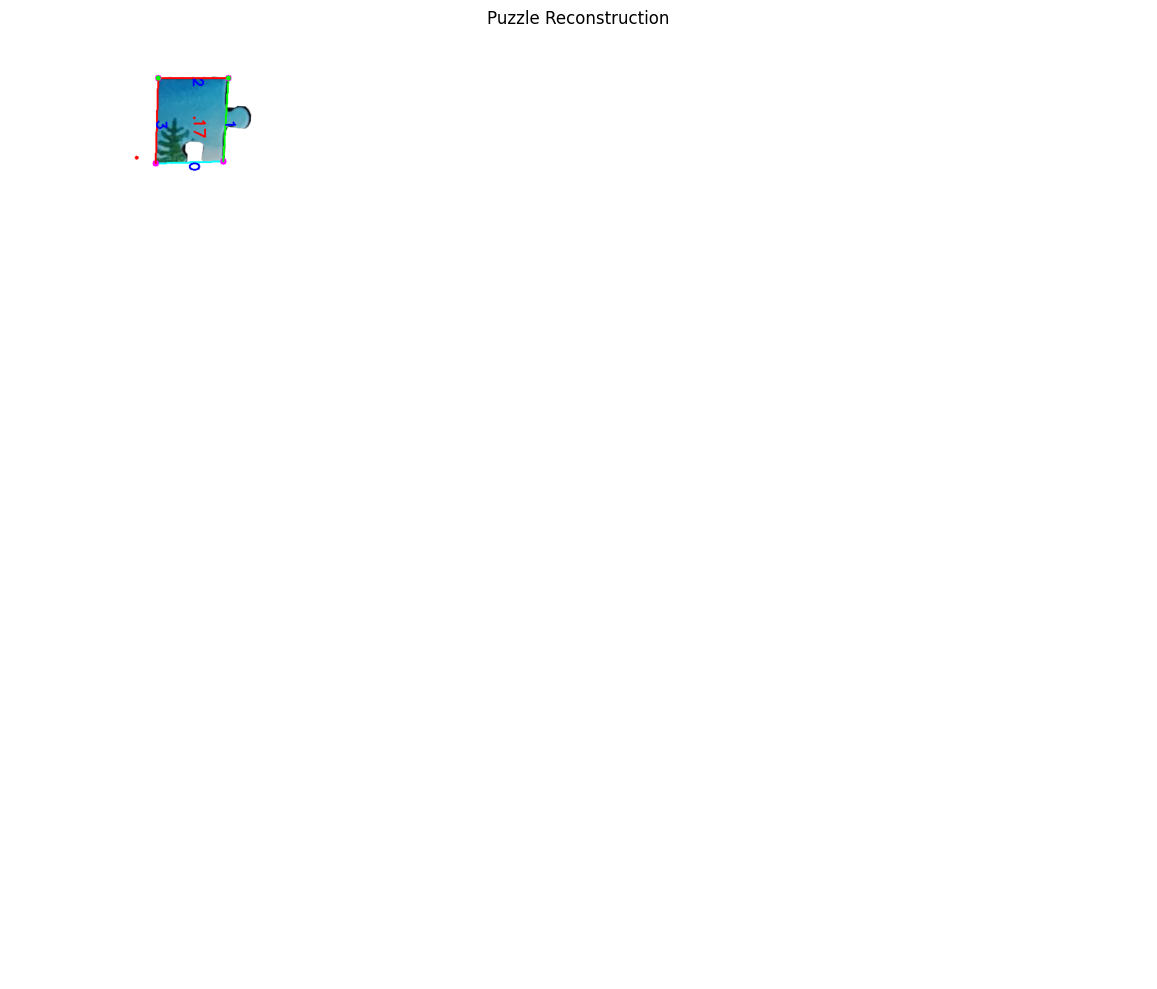


Corner piece placement complete!


In [1759]:

print(f"Placing corner piece {corner_piece_id} with {rotations_needed * 90}° rotation")

# Place the piece with the calculated rotation
# This should put the flat edges in North (0) and West (3) positions
puzzle_reconstruction.place_piece(corner_piece, 0, 0, rotations=rotations_needed)

# Print verification
flat_edge_indices_after = [(i + rotations_needed) % 4 for i in flat_edge_indices]
print(f"Flat edges after rotation: {flat_edge_indices_after}")

# Track placed pieces
placed_pieces = {corner_piece_id}
grid = {(0, 0): corner_piece_id}

# Save the result
result_path = os.path.join(output_canvas, "corner_piece_oriented.png")
puzzle_reconstruction.save(result_path)
print(f"Result saved to {result_path}")

# Display the canvas in the notebook
puzzle_reconstruction.display()

print("\nCorner piece placement complete!")